# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/oversampled-2.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (14169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
1,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
2,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
4,deklarasi pilkada 2018 aman dan anti hoax warg...,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
data.HS.value_counts()

HS
0    8084
1    6085
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8084
1    6085
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (8309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(11335,) (11335, 12)
(2834,) (2834, 12)


In [14]:
hs_mask = (
    (val_data['Abusive'] == 0) & 
    (val_data['HS'] == 0)
)
hs = val_data[hs_mask]
print(hs.shape)

(1213, 13)


# BUILD DATASET & DATALOADERS

In [15]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [16]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 250

In [18]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [20]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [21]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

In [22]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in most_uncertain_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

In [23]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

In [24]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

In [25]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'HS': [y_train[i][0] for i in temp],
            'Abusive': [y_train[i][1] for i in temp],
            'HS_Individual': [y_train[i][2] for i in temp],
            'HS_Group': [y_train[i][3] for i in temp],
            'HS_Religion': [y_train[i][4] for i in temp],
            'HS_Race': [y_train[i][5] for i in temp],
            'HS_Physical': [y_train[i][6] for i in temp],
            'HS_Gender': [y_train[i][7] for i in temp],
            'HS_Other': [y_train[i][8] for i in temp],
            'HS_Weak': [y_train[i][9] for i in temp],
            'HS_Moderate': [y_train[i][10] for i in temp],
            'HS_Strong': [y_train[i][11] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [26]:
def active_learning(seed, i, sampling_strategy):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()
    filename = f'hsd-{sampling_strategy}'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model-{percentage}')
        
        # Perform query strategy to select new samples
        new_samples = manager.list()
        if sampling_strategy == 'lc':
            print("LC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'mc':
            print("MC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'kmeans':
            print("KMeans")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
            notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'coreset':
            print("Coreset")
            sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'random':
            print("Random")
            random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
            
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)
    print(f"Result saved to results/{filename}-{i+1}-results.csv")

# LEAST CONFIDENCE

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.651, Accuracy: 0.802, F1 Micro: 0.4002, F1 Macro: 0.1143
Epoch 2/10, Train Loss: 0.4865, Accuracy: 0.8303, F1 Micro: 0.1548, F1 Macro: 0.0486
Epoch 3/10, Train Loss: 0.4284, Accuracy: 0.8298, F1 Micro: 0.1357, F1 Macro: 0.0475
Epoch 4/10, Train Loss: 0.4021, Accuracy: 0.8325, F1 Micro: 0.166, F1 Macro: 0.0558
Epoch 5/10, Train Loss: 0.392, Accuracy: 0.8478, F1 Micro: 0.352, F1 Macro: 0.1202
Epoch 6/10, Train Loss: 0.3906, Accuracy: 0.8493, F1 Micro: 0.3887, F1 Macro: 0.1458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3595, Accuracy: 0.8523, F1 Micro: 0.413, F1 Macro: 0.1775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3511, Accuracy: 0.8584, F1 Micro: 0.4489, F1 Macro: 0.2282
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3248, Accuracy: 0.8663, F1 Micro: 0.5084, F1 Macro: 0.2815
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2992, Accuracy: 0.8736, F1 Micro: 0.548, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5003, Accuracy: 0.8206, F1 Micro: 0.0025, F1 Macro: 0.0011
Epoch 2/10, Train Loss: 0.2939, Accuracy: 0.8205, F1 Micro: 0.0016, F1 Macro: 0.0007
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.263, Accuracy: 0.8235, F1 Micro: 0.0444, F1 Macro: 0.0172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2597, Accuracy: 0.835, F1 Micro: 0.2016, F1 Macro: 0.0654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2247, Accuracy: 0.8478, F1 Micro: 0.3146, F1 Macro: 0.1047
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2031, Accuracy: 0.8633, F1 Micro: 0.476, F1 Macro: 0.2059
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1721, Accuracy: 0.8666, F1 Micro: 0.4894, F1 Macro: 0.2312
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1558, Accuracy: 0.8723, F1 Micro: 0.5641, F1 Macro: 0.3483
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1361, Accuracy: 0.8752, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4157, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.8253, F1 Micro: 0.0694, F1 Macro: 0.0253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1988, Accuracy: 0.8477, F1 Micro: 0.3422, F1 Macro: 0.117
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.8603, F1 Micro: 0.4962, F1 Macro: 0.2351
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1439, Accuracy: 0.87, F1 Micro: 0.5245, F1 Macro: 0.263
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1312, Accuracy: 0.8742, F1 Micro: 0.5723, F1 Macro: 0.3707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1111, Accuracy: 0.8781, F1 Micro: 0.636, F1 Macro: 0.4803
Epoch 9/10, Train Loss: 0.0935, Accuracy: 0.8832, F1 Micro: 0.6329, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3726, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2234, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.8223, F1 Micro: 0.0212, F1 Macro: 0.0087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.8519, F1 Micro: 0.3457, F1 Macro: 0.125
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.8669, F1 Micro: 0.5449, F1 Macro: 0.2566
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.8734, F1 Micro: 0.541, F1 Macro: 0.2678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.8778, F1 Micro: 0.6238, F1 Macro: 0.4481
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.8816, F1 Micro: 0.5803, F1 Macro: 0.4039
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.8921, F1 Micro: 0.6757, F1 Macro: 0.5666
Epoch 10/10, Train

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3498, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2165, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.8204, F1 Micro: 0.0003, F1 Macro: 0.0001
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.8555, F1 Micro: 0.3698, F1 Macro: 0.1479
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.8716, F1 Micro: 0.563, F1 Macro: 0.2826
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.8796, F1 Micro: 0.6117, F1 Macro: 0.394
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.8855, F1 Micro: 0.6115, F1 Macro: 0.4443
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.8905, F1 Micro: 0.6904, F1 Macro: 0.5787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.8985, F1 Micro: 0.7051, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3372, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2158, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.827, F1 Micro: 0.0734, F1 Macro: 0.0273
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.8646, F1 Micro: 0.4522, F1 Macro: 0.2059
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.88, F1 Micro: 0.5716, F1 Macro: 0.3459
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.8899, F1 Micro: 0.6652, F1 Macro: 0.5229
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.8995, F1 Micro: 0.7018, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.903, F1 Micro: 0.7092, F1 Macro: 0.5923
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0654, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3381, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2292, Accuracy: 0.8209, F1 Micro: 0.0066, F1 Macro: 0.0028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.8459, F1 Micro: 0.2617, F1 Macro: 0.1009
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.8825, F1 Micro: 0.6125, F1 Macro: 0.4229
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.8945, F1 Micro: 0.6725, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9036, F1 Micro: 0.7296, F1 Macro: 0.6539
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9062, F1 Micro: 0.706, F1 Macro: 0.5802
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9048, F1 Micro: 0.7414, F1 Macro: 0.6752
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9112, F1 Micro: 0.7197, F1 Macro: 0.6351
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3515, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2417, Accuracy: 0.8414, F1 Micro: 0.2719, F1 Macro: 0.1862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.8661, F1 Micro: 0.4571, F1 Macro: 0.3382
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.8976, F1 Micro: 0.6876, F1 Macro: 0.5666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9056, F1 Micro: 0.7039, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9092, F1 Micro: 0.7333, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0894, Accuracy: 0.9093, F1 Micro: 0.7422, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9156, F1 Micro: 0.7548, F1 Macro: 0.674
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0657

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3563, Accuracy: 0.8204, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.849, F1 Micro: 0.2976, F1 Macro: 0.2295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.8931, F1 Micro: 0.6461, F1 Macro: 0.5155
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.8891, F1 Micro: 0.5833, F1 Macro: 0.4532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9114, F1 Micro: 0.732, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9143, F1 Micro: 0.7553, F1 Macro: 0.6839
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9185, F1 Micro: 0.7622, F1 Macro: 0.6987
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9211, F1 Micro: 0.7735, F1 Macro: 0.7161
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.924, F1 Micro: 0.7734, F1 Macro: 0.7118
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3649, Accuracy: 0.8227, F1 Micro: 0.0273, F1 Macro: 0.0128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.8568, F1 Micro: 0.3566, F1 Macro: 0.2549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.8972, F1 Micro: 0.6558, F1 Macro: 0.531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.911, F1 Micro: 0.7276, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9162, F1 Micro: 0.7505, F1 Macro: 0.6799
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9182, F1 Micro: 0.7639, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9206, F1 Micro: 0.7678, F1 Macro: 0.7068
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9239, F1 Micro: 0.7741, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3712, Accuracy: 0.8417, F1 Micro: 0.2774, F1 Macro: 0.1366
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.8791, F1 Micro: 0.5312, F1 Macro: 0.3873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9044, F1 Micro: 0.6877, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9111, F1 Micro: 0.7415, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9203, F1 Micro: 0.7607, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9226, F1 Micro: 0.7748, F1 Macro: 0.7246
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9239, F1 Micro: 0.7722, F1 Macro: 0.7274
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.924, F1 Micro: 0.7871, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.9284, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.8464, F1 Micro: 0.2952, F1 Macro: 0.1545
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.8924, F1 Micro: 0.6655, F1 Macro: 0.5261
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9073, F1 Micro: 0.7028, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9161, F1 Micro: 0.7667, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.925, F1 Micro: 0.7742, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9286, F1 Micro: 0.7906, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9287, F1 Micro: 0.7947, F1 Macro: 0.7571
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9285, F1 Micro: 0.7974, F1 Macro: 0.7547
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.382, Accuracy: 0.8538, F1 Micro: 0.3849, F1 Macro: 0.2267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2561, Accuracy: 0.8976, F1 Micro: 0.651, F1 Macro: 0.5283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9152, F1 Micro: 0.743, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9229, F1 Micro: 0.7676, F1 Macro: 0.7035
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9289, F1 Micro: 0.7902, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9303, F1 Micro: 0.7995, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0825, Accuracy: 0.9318, F1 Micro: 0.8064, F1 Macro: 0.7713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9314, F1 Micro: 0.8113, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0602

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.8588, F1 Micro: 0.4123, F1 Macro: 0.2336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9015, F1 Micro: 0.6811, F1 Macro: 0.5672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1928, Accuracy: 0.9176, F1 Micro: 0.7457, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9255, F1 Micro: 0.7845, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9291, F1 Micro: 0.7968, F1 Macro: 0.7527
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9323, F1 Micro: 0.8084, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9341, F1 Micro: 0.8118, F1 Macro: 0.7786
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9322, F1 Micro: 0.8115, F1 Macro: 0.7803
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9344, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3927, Accuracy: 0.8688, F1 Micro: 0.4992, F1 Macro: 0.2783
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.8982, F1 Micro: 0.6438, F1 Macro: 0.5256
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.922, F1 Micro: 0.7741, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9279, F1 Micro: 0.7842, F1 Macro: 0.7395
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9318, F1 Micro: 0.7976, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9335, F1 Micro: 0.8141, F1 Macro: 0.7823
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.9346, F1 Micro: 0.8074, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9371, F1 Micro: 0.821, F1 Macro: 0.7891
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9385, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.393, Accuracy: 0.8653, F1 Micro: 0.4508, F1 Macro: 0.2569
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2569, Accuracy: 0.9028, F1 Micro: 0.7257, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1886, Accuracy: 0.9236, F1 Micro: 0.7803, F1 Macro: 0.7202
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9312, F1 Micro: 0.8038, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9346, F1 Micro: 0.8164, F1 Macro: 0.7826
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9338, F1 Micro: 0.8171, F1 Macro: 0.7854
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9361, F1 Micro: 0.8218, F1 Macro: 0.7921
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.932, F1 Micro: 0.8176, F1 Macro: 0.7907
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9359, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3956, Accuracy: 0.8699, F1 Micro: 0.5008, F1 Macro: 0.3163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.9034, F1 Micro: 0.6792, F1 Macro: 0.5728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9244, F1 Micro: 0.7893, F1 Macro: 0.742
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9315, F1 Micro: 0.7998, F1 Macro: 0.7573
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9361, F1 Micro: 0.8133, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9365, F1 Micro: 0.8146, F1 Macro: 0.7834
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9389, F1 Micro: 0.8246, F1 Macro: 0.7966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9402, F1 Micro: 0.8329, F1 Macro: 0.809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3945, Accuracy: 0.8776, F1 Micro: 0.5597, F1 Macro: 0.3652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.9126, F1 Micro: 0.7304, F1 Macro: 0.6513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1941, Accuracy: 0.927, F1 Micro: 0.7868, F1 Macro: 0.7377
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9338, F1 Micro: 0.8106, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.937, F1 Micro: 0.8187, F1 Macro: 0.7865
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9387, F1 Micro: 0.8242, F1 Macro: 0.7974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9397, F1 Micro: 0.8243, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9406, F1 Micro: 0.8248, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3957, Accuracy: 0.8808, F1 Micro: 0.5783, F1 Macro: 0.3935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2485, Accuracy: 0.9139, F1 Micro: 0.7327, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.9293, F1 Micro: 0.795, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9318, F1 Micro: 0.8069, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9368, F1 Micro: 0.8247, F1 Macro: 0.7957
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9399, F1 Micro: 0.8318, F1 Macro: 0.8053
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9438, F1 Micro: 0.842, F1 Macro: 0.821
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.941, F1 Micro: 0.8374, F1 Macro: 0.8158
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9417, F1 Micro: 0.8401, F1 Macro: 0.8191
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3953, Accuracy: 0.8842, F1 Micro: 0.6182, F1 Macro: 0.4362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.9181, F1 Micro: 0.7595, F1 Macro: 0.693
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9308, F1 Micro: 0.7982, F1 Macro: 0.7574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9347, F1 Micro: 0.8118, F1 Macro: 0.7768
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9404, F1 Micro: 0.8277, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9404, F1 Micro: 0.8344, F1 Macro: 0.8128
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9402, F1 Micro: 0.8376, F1 Macro: 0.8159
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9423, F1 Micro: 0.8417, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3899, Accuracy: 0.8865, F1 Micro: 0.6159, F1 Macro: 0.4778
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9172, F1 Micro: 0.7478, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9325, F1 Micro: 0.8002, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9374, F1 Micro: 0.8188, F1 Macro: 0.7857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9402, F1 Micro: 0.8285, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9426, F1 Micro: 0.8314, F1 Macro: 0.8048
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9433, F1 Micro: 0.8354, F1 Macro: 0.8149
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.946, F1 Micro: 0.8479, F1 Macro: 0.8275
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9447, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3966, Accuracy: 0.8895, F1 Micro: 0.6388, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.9211, F1 Micro: 0.7743, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9326, F1 Micro: 0.8013, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9381, F1 Micro: 0.8153, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9408, F1 Micro: 0.8362, F1 Macro: 0.8089
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9416, F1 Micro: 0.8398, F1 Macro: 0.8142
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9449, F1 Micro: 0.8463, F1 Macro: 0.8272
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9474, F1 Micro: 0.8465, F1 Macro: 0.8299
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3968, Accuracy: 0.8865, F1 Micro: 0.6102, F1 Macro: 0.4817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.9215, F1 Micro: 0.7664, F1 Macro: 0.7112
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.932, F1 Micro: 0.8081, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9397, F1 Micro: 0.8312, F1 Macro: 0.7998
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.944, F1 Micro: 0.8377, F1 Macro: 0.8099
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9471, F1 Micro: 0.8471, F1 Macro: 0.8258
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9468, F1 Micro: 0.8466, F1 Macro: 0.8263
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9435, F1 Micro: 0.8469, F1 Macro: 0.8296
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9461, F1 Micro: 0.8531, F1 Macro: 0.8383
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3892, Accuracy: 0.8932, F1 Micro: 0.6639, F1 Macro: 0.5347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2406, Accuracy: 0.922, F1 Micro: 0.7594, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9342, F1 Micro: 0.8107, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.94, F1 Micro: 0.8213, F1 Macro: 0.7911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1187, Accuracy: 0.9436, F1 Micro: 0.8376, F1 Macro: 0.8116
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9429, F1 Micro: 0.8432, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9465, F1 Micro: 0.8516, F1 Macro: 0.8328
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9491, F1 Micro: 0.8571, F1 Macro: 0.838
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0544,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3907, Accuracy: 0.8945, F1 Micro: 0.6649, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2439, Accuracy: 0.9223, F1 Micro: 0.7769, F1 Macro: 0.7245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.9372, F1 Micro: 0.8166, F1 Macro: 0.783
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.937, F1 Micro: 0.8069, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9423, F1 Micro: 0.8367, F1 Macro: 0.8102
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9481, F1 Micro: 0.8527, F1 Macro: 0.8308
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9488, F1 Micro: 0.8544, F1 Macro: 0.8369
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9484, F1 Micro: 0.857, F1 Macro: 0.8417
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9483, F1 Micro: 0.8564, F1 Macro: 0.843
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.8895, F1 Micro: 0.6123, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.9229, F1 Micro: 0.7552, F1 Macro: 0.6878
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9365, F1 Micro: 0.8146, F1 Macro: 0.7778
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9409, F1 Micro: 0.8261, F1 Macro: 0.7987
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9475, F1 Micro: 0.847, F1 Macro: 0.8231
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9463, F1 Micro: 0.8504, F1 Macro: 0.8311
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.9484, F1 Micro: 0.8559, F1 Macro: 0.8398
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9468, F1 Micro: 0.8545, F1 Macro: 0.8395
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9475, F1 Micro

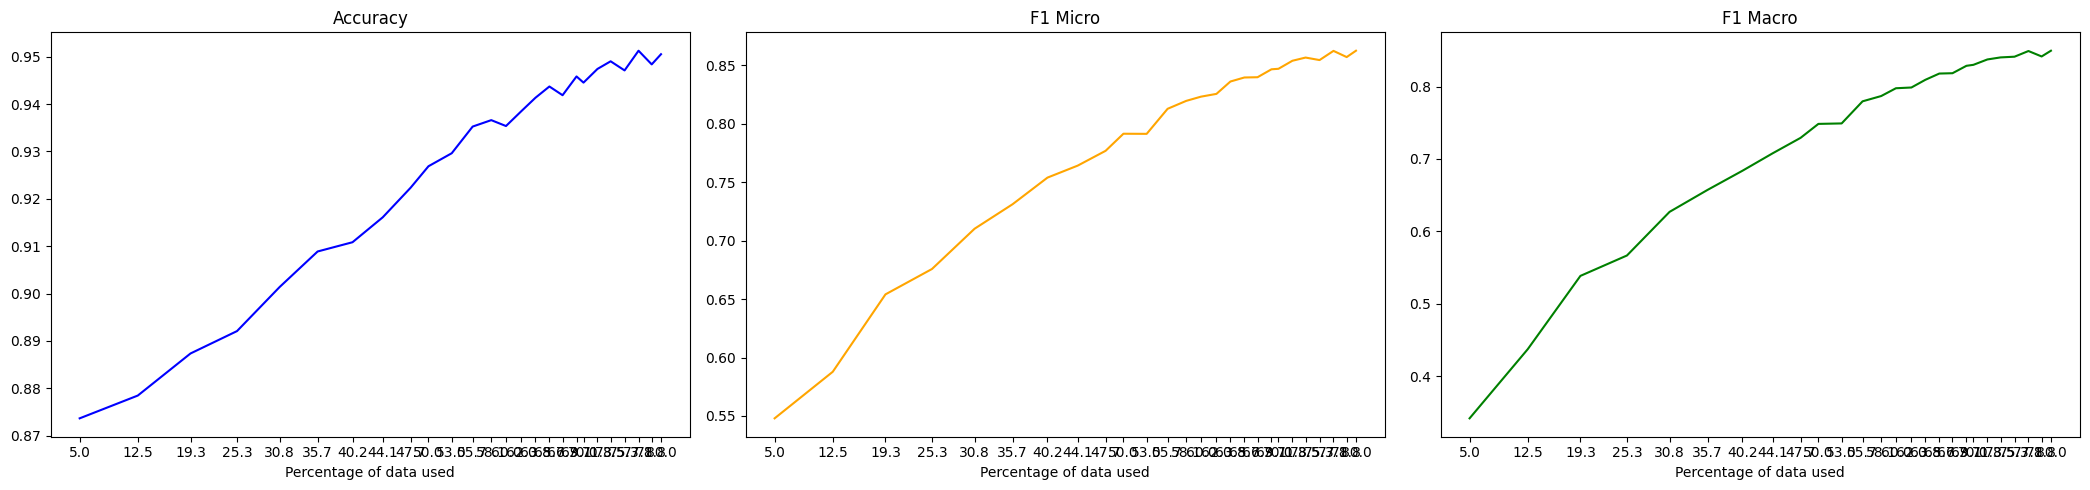

Result saved to results/hsd-lc-1-results.csv


In [ ]:
active_learning(42, 0, 'lc')

# MONTE CARLO DROPOUT

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.651, Accuracy: 0.802, F1 Micro: 0.4002, F1 Macro: 0.1143
Epoch 2/10, Train Loss: 0.4865, Accuracy: 0.8303, F1 Micro: 0.1548, F1 Macro: 0.0486
Epoch 3/10, Train Loss: 0.4284, Accuracy: 0.8298, F1 Micro: 0.1357, F1 Macro: 0.0475
Epoch 4/10, Train Loss: 0.4021, Accuracy: 0.8325, F1 Micro: 0.166, F1 Macro: 0.0558
Epoch 5/10, Train Loss: 0.392, Accuracy: 0.8478, F1 Micro: 0.352, F1 Macro: 0.1202
Epoch 6/10, Train Loss: 0.3906, Accuracy: 0.8493, F1 Micro: 0.3887, F1 Macro: 0.1458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3595, Accuracy: 0.8523, F1 Micro: 0.413, F1 Macro: 0.1775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3511, Accuracy: 0.8584, F1 Micro: 0.4489, F1 Macro: 0.2282
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3248, Accuracy: 0.8663, F1 Micro: 0.5084, F1 Macro: 0.2815
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2992, Accuracy: 0.8736, F1 Micro: 0.548, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5782, Accuracy: 0.8195, F1 Micro: 0.3017, F1 Macro: 0.0783
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4663, Accuracy: 0.8342, F1 Micro: 0.4149, F1 Macro: 0.1419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4298, Accuracy: 0.8509, F1 Micro: 0.4586, F1 Macro: 0.2453
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4009, Accuracy: 0.8641, F1 Micro: 0.5612, F1 Macro: 0.3838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3605, Accuracy: 0.8833, F1 Micro: 0.5804, F1 Macro: 0.4314
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3164, Accuracy: 0.8933, F1 Micro: 0.6401, F1 Macro: 0.5133
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2766, Accuracy: 0.9024, F1 Micro: 0.6886, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2494, Accuracy: 0.9077, F1 Micro: 0.718, F1 Macro: 0.6404
Epoch 9/10, Train Loss: 0.2226, Accuracy: 0.9077, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5459, Accuracy: 0.8201, F1 Micro: 0.3904, F1 Macro: 0.1051
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4503, Accuracy: 0.8431, F1 Micro: 0.4349, F1 Macro: 0.2095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4044, Accuracy: 0.8651, F1 Micro: 0.5383, F1 Macro: 0.3631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3645, Accuracy: 0.8933, F1 Micro: 0.6538, F1 Macro: 0.5367
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3181, Accuracy: 0.9083, F1 Micro: 0.7081, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.272, Accuracy: 0.9161, F1 Micro: 0.735, F1 Macro: 0.6643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2267, Accuracy: 0.9208, F1 Micro: 0.7592, F1 Macro: 0.7076
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1922, Accuracy: 0.9275, F1 Micro: 0.7866, F1 Macro: 0.7457
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5193, Accuracy: 0.8287, F1 Micro: 0.4117, F1 Macro: 0.1386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4286, Accuracy: 0.8494, F1 Micro: 0.4939, F1 Macro: 0.2838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3854, Accuracy: 0.8806, F1 Micro: 0.6097, F1 Macro: 0.4564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3387, Accuracy: 0.906, F1 Micro: 0.732, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2866, Accuracy: 0.9193, F1 Micro: 0.7733, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.24, Accuracy: 0.9301, F1 Micro: 0.7946, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2027, Accuracy: 0.9322, F1 Micro: 0.8026, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1708, Accuracy: 0.9333, F1 Micro: 0.8063, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5151, Accuracy: 0.8317, F1 Micro: 0.417, F1 Macro: 0.1438
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4198, Accuracy: 0.8535, F1 Micro: 0.5632, F1 Macro: 0.4076
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3684, Accuracy: 0.899, F1 Micro: 0.6811, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3153, Accuracy: 0.918, F1 Micro: 0.7566, F1 Macro: 0.6997
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2669, Accuracy: 0.9314, F1 Micro: 0.8009, F1 Macro: 0.7617
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2157, Accuracy: 0.9358, F1 Micro: 0.8117, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1814, Accuracy: 0.9388, F1 Micro: 0.8268, F1 Macro: 0.7974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1494, Accuracy: 0.941, F1 Micro: 0.8308, F1 Macro: 0.8048
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5057, Accuracy: 0.8331, F1 Micro: 0.4368, F1 Macro: 0.2
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4108, Accuracy: 0.869, F1 Micro: 0.5827, F1 Macro: 0.4218
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3586, Accuracy: 0.9065, F1 Micro: 0.69, F1 Macro: 0.5972
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3001, Accuracy: 0.9254, F1 Micro: 0.7912, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2448, Accuracy: 0.9347, F1 Micro: 0.8054, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2028, Accuracy: 0.94, F1 Micro: 0.8219, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1681, Accuracy: 0.941, F1 Micro: 0.8262, F1 Macro: 0.8032
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1375, Accuracy: 0.9448, F1 Micro: 0.8393, F1 Macro: 0.8191
Epoch 9/10, Train Loss: 0.1177, Accuracy: 0.9425, F1 Micro: 0.8326

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4977, Accuracy: 0.8362, F1 Micro: 0.4556, F1 Macro: 0.2145
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4036, Accuracy: 0.8882, F1 Micro: 0.6398, F1 Macro: 0.5093
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3348, Accuracy: 0.9147, F1 Micro: 0.7365, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2738, Accuracy: 0.9298, F1 Micro: 0.7913, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2307, Accuracy: 0.9373, F1 Micro: 0.8119, F1 Macro: 0.7831
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.186, Accuracy: 0.9401, F1 Micro: 0.8289, F1 Macro: 0.8048
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1505, Accuracy: 0.9409, F1 Micro: 0.8345, F1 Macro: 0.8137
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1334, Accuracy: 0.9435, F1 Micro: 0.8349, F1 Macro: 0.8154
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4878, Accuracy: 0.842, F1 Micro: 0.4765, F1 Macro: 0.2456
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3871, Accuracy: 0.901, F1 Micro: 0.6835, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3098, Accuracy: 0.923, F1 Micro: 0.7603, F1 Macro: 0.6992
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2526, Accuracy: 0.9327, F1 Micro: 0.8032, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2104, Accuracy: 0.9383, F1 Micro: 0.822, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1739, Accuracy: 0.9446, F1 Micro: 0.8388, F1 Macro: 0.813
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1434, Accuracy: 0.9435, F1 Micro: 0.839, F1 Macro: 0.8223
Epoch 8/10, Train Loss: 0.1189, Accuracy: 0.9375, F1 Micro: 0.8304, F1 Macro: 0.8152
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1061, Accuracy: 0.945, F1 Micro: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4813, Accuracy: 0.8451, F1 Micro: 0.4862, F1 Macro: 0.2587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3714, Accuracy: 0.9032, F1 Micro: 0.7023, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3027, Accuracy: 0.9256, F1 Micro: 0.7799, F1 Macro: 0.7332
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2424, Accuracy: 0.9359, F1 Micro: 0.8072, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2016, Accuracy: 0.9396, F1 Micro: 0.8321, F1 Macro: 0.8092
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1632, Accuracy: 0.943, F1 Micro: 0.8394, F1 Macro: 0.8163
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.136, Accuracy: 0.9465, F1 Micro: 0.8468, F1 Macro: 0.8278
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1128, Accuracy: 0.9451, F1 Micro: 0.8469, F1 Macro: 0.8327
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4726, Accuracy: 0.8505, F1 Micro: 0.4971, F1 Macro: 0.2791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3606, Accuracy: 0.9074, F1 Micro: 0.7036, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2907, Accuracy: 0.9285, F1 Micro: 0.7845, F1 Macro: 0.7391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.239, Accuracy: 0.9375, F1 Micro: 0.8215, F1 Macro: 0.7904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1895, Accuracy: 0.9407, F1 Micro: 0.8319, F1 Macro: 0.8059
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1579, Accuracy: 0.9402, F1 Micro: 0.8373, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1274, Accuracy: 0.9448, F1 Micro: 0.8446, F1 Macro: 0.8235
Epoch 8/10, Train Loss: 0.1132, Accuracy: 0.9433, F1 Micro: 0.8443, F1 Macro: 0.8271
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0934, Accuracy: 0.9487, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4707, Accuracy: 0.8535, F1 Micro: 0.5098, F1 Macro: 0.2967
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3498, Accuracy: 0.9107, F1 Micro: 0.7341, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2707, Accuracy: 0.9294, F1 Micro: 0.7905, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2246, Accuracy: 0.9406, F1 Micro: 0.8277, F1 Macro: 0.7991
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1756, Accuracy: 0.9435, F1 Micro: 0.8378, F1 Macro: 0.8157
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9477, F1 Micro: 0.8463, F1 Macro: 0.8258
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9484, F1 Micro: 0.852, F1 Macro: 0.8387
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0993, Accuracy: 0.9485, F1 Micro: 0.8541, F1 Macro: 0.841
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9461, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4589, Accuracy: 0.8603, F1 Micro: 0.5246, F1 Macro: 0.3097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3362, Accuracy: 0.9132, F1 Micro: 0.7358, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2634, Accuracy: 0.9312, F1 Micro: 0.7876, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2168, Accuracy: 0.9383, F1 Micro: 0.8235, F1 Macro: 0.7928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1733, Accuracy: 0.9433, F1 Micro: 0.8377, F1 Macro: 0.8156
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1414, Accuracy: 0.9466, F1 Micro: 0.845, F1 Macro: 0.8249
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1204, Accuracy: 0.9459, F1 Micro: 0.8489, F1 Macro: 0.8345
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9477, F1 Micro: 0.8542, F1 Macro: 0.8376
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4513, Accuracy: 0.868, F1 Micro: 0.5537, F1 Macro: 0.371
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3255, Accuracy: 0.9133, F1 Micro: 0.72, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2531, Accuracy: 0.9328, F1 Micro: 0.8034, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2015, Accuracy: 0.9416, F1 Micro: 0.8262, F1 Macro: 0.7993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1606, Accuracy: 0.9402, F1 Micro: 0.8369, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.944, F1 Micro: 0.843, F1 Macro: 0.8239
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9481, F1 Micro: 0.8527, F1 Macro: 0.8378
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9456, F1 Micro: 0.8492, F1 Macro: 0.8327
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0.9448, F1 Micro: 0.8506, F1 Macro: 0.8376
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4512, Accuracy: 0.8728, F1 Micro: 0.586, F1 Macro: 0.4104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.317, Accuracy: 0.9186, F1 Micro: 0.7461, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2429, Accuracy: 0.9337, F1 Micro: 0.8065, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1977, Accuracy: 0.939, F1 Micro: 0.8236, F1 Macro: 0.7946
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.944, F1 Micro: 0.8391, F1 Macro: 0.8152
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9477, F1 Micro: 0.8516, F1 Macro: 0.8317
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9433, F1 Micro: 0.8451, F1 Macro: 0.8301
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9496, F1 Micro: 0.8591, F1 Macro: 0.8426
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9447, F1 Micro: 0.85, F1 Macro: 0.8367
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4461, Accuracy: 0.8757, F1 Micro: 0.5968, F1 Macro: 0.4396
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3112, Accuracy: 0.9221, F1 Micro: 0.7668, F1 Macro: 0.7148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.236, Accuracy: 0.9297, F1 Micro: 0.8077, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1918, Accuracy: 0.9392, F1 Micro: 0.83, F1 Macro: 0.8014
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9455, F1 Micro: 0.8423, F1 Macro: 0.8206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9453, F1 Micro: 0.8467, F1 Macro: 0.8268
Epoch 7/10, Train Loss: 0.1042, Accuracy: 0.9413, F1 Micro: 0.8419, F1 Macro: 0.8254
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9468, F1 Micro: 0.8527, F1 Macro: 0.8371
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9515, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4413, Accuracy: 0.8788, F1 Micro: 0.6188, F1 Macro: 0.468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3039, Accuracy: 0.9214, F1 Micro: 0.7566, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2335, Accuracy: 0.934, F1 Micro: 0.8088, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.94, F1 Micro: 0.8218, F1 Macro: 0.7924
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.9384, F1 Micro: 0.8322, F1 Macro: 0.8087
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.9466, F1 Micro: 0.8459, F1 Macro: 0.8277
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9475, F1 Micro: 0.8528, F1 Macro: 0.8377
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9485, F1 Micro: 0.8567, F1 Macro: 0.842
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.435, Accuracy: 0.8798, F1 Micro: 0.6195, F1 Macro: 0.469
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2953, Accuracy: 0.9211, F1 Micro: 0.7569, F1 Macro: 0.7028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.9359, F1 Micro: 0.8152, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9419, F1 Micro: 0.8303, F1 Macro: 0.8035
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9472, F1 Micro: 0.848, F1 Macro: 0.8249
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9459, F1 Micro: 0.8477, F1 Macro: 0.8257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.949, F1 Micro: 0.8558, F1 Macro: 0.8405
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9501, F1 Micro: 0.8588, F1 Macro: 0.8443
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9507, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4282, Accuracy: 0.8849, F1 Micro: 0.5931, F1 Macro: 0.4329
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.9203, F1 Micro: 0.7795, F1 Macro: 0.7409
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2188, Accuracy: 0.9349, F1 Micro: 0.8133, F1 Macro: 0.7784
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9388, F1 Micro: 0.8297, F1 Macro: 0.8038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9465, F1 Micro: 0.8438, F1 Macro: 0.8192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.947, F1 Micro: 0.8517, F1 Macro: 0.8332
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9496, F1 Micro: 0.8581, F1 Macro: 0.842
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9531, F1 Micro: 0.8642, F1 Macro: 0.8482
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.95, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4244, Accuracy: 0.8852, F1 Micro: 0.5867, F1 Macro: 0.4489
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2801, Accuracy: 0.9222, F1 Micro: 0.7599, F1 Macro: 0.703
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9356, F1 Micro: 0.8188, F1 Macro: 0.7861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9359, F1 Micro: 0.8253, F1 Macro: 0.7984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9433, F1 Micro: 0.841, F1 Macro: 0.8186
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9466, F1 Micro: 0.8475, F1 Macro: 0.8243
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9479, F1 Micro: 0.8532, F1 Macro: 0.8384
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9501, F1 Micro: 0.8596, F1 Macro: 0.8456
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.948, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4232, Accuracy: 0.8881, F1 Micro: 0.6122, F1 Macro: 0.4755
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.92, F1 Micro: 0.7452, F1 Macro: 0.6931
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.9348, F1 Micro: 0.7999, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9369, F1 Micro: 0.8287, F1 Macro: 0.8037
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9439, F1 Micro: 0.8448, F1 Macro: 0.8227
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.947, F1 Micro: 0.8517, F1 Macro: 0.8356
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9486, F1 Micro: 0.8552, F1 Macro: 0.8393
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9534, F1 Micro: 0.8663, F1 Macro: 0.8536
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9526, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4182, Accuracy: 0.8882, F1 Micro: 0.6205, F1 Macro: 0.4908
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.9264, F1 Micro: 0.7788, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9363, F1 Micro: 0.8138, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9404, F1 Micro: 0.8281, F1 Macro: 0.8005
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9466, F1 Micro: 0.848, F1 Macro: 0.8245
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9479, F1 Micro: 0.8539, F1 Macro: 0.8351
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9482, F1 Micro: 0.8545, F1 Macro: 0.8371
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9482, F1 Micro: 0.8554, F1 Macro: 0.8393
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4111, Accuracy: 0.8897, F1 Micro: 0.6289, F1 Macro: 0.5139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.9239, F1 Micro: 0.7742, F1 Macro: 0.7202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9351, F1 Micro: 0.8056, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9336, F1 Micro: 0.8176, F1 Macro: 0.7928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9421, F1 Micro: 0.8413, F1 Macro: 0.8183
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1034, Accuracy: 0.9466, F1 Micro: 0.851, F1 Macro: 0.8313
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9494, F1 Micro: 0.8566, F1 Macro: 0.8373
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9515, F1 Micro: 0.8623, F1 Macro: 0.846
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4066, Accuracy: 0.8909, F1 Micro: 0.6354, F1 Macro: 0.507
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.9251, F1 Micro: 0.7759, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9337, F1 Micro: 0.8059, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.9385, F1 Micro: 0.8305, F1 Macro: 0.7999
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9451, F1 Micro: 0.845, F1 Macro: 0.8211
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9483, F1 Micro: 0.8533, F1 Macro: 0.8307
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9498, F1 Micro: 0.8581, F1 Macro: 0.843
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9479, F1 Micro: 0.8578, F1 Macro: 0.8433
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9524, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4007, Accuracy: 0.8913, F1 Micro: 0.6263, F1 Macro: 0.4726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.9244, F1 Micro: 0.7792, F1 Macro: 0.7305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1895, Accuracy: 0.9343, F1 Micro: 0.8135, F1 Macro: 0.7797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9427, F1 Micro: 0.8358, F1 Macro: 0.8079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9455, F1 Micro: 0.8458, F1 Macro: 0.8229
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9479, F1 Micro: 0.8512, F1 Macro: 0.832
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.95, F1 Micro: 0.8578, F1 Macro: 0.841
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9481, F1 Micro: 0.8561, F1 Macro: 0.8389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9506, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.8937, F1 Micro: 0.6575, F1 Macro: 0.5161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.9241, F1 Micro: 0.7776, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.9361, F1 Micro: 0.8141, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9428, F1 Micro: 0.8314, F1 Macro: 0.8011
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9456, F1 Micro: 0.8458, F1 Macro: 0.8247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9467, F1 Micro: 0.8521, F1 Macro: 0.832
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9474, F1 Micro: 0.8515, F1 Macro: 0.8343
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9504, F1 Micro: 0.8621, F1 Macro: 0.8485
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9498, F1 Micro: 0.8605, F1 Macro: 0.8465
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3917, Accuracy: 0.8954, F1 Micro: 0.668, F1 Macro: 0.5497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2442, Accuracy: 0.9243, F1 Micro: 0.7616, F1 Macro: 0.708
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.9349, F1 Micro: 0.8109, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9389, F1 Micro: 0.8257, F1 Macro: 0.7992
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9468, F1 Micro: 0.8463, F1 Macro: 0.8243
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9473, F1 Micro: 0.8523, F1 Macro: 0.8336
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9495, F1 Micro: 0.8573, F1 Macro: 0.8438
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.951, F1 Micro: 0.8627, F1 Macro: 0.8476
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.949, F1 Micro: 

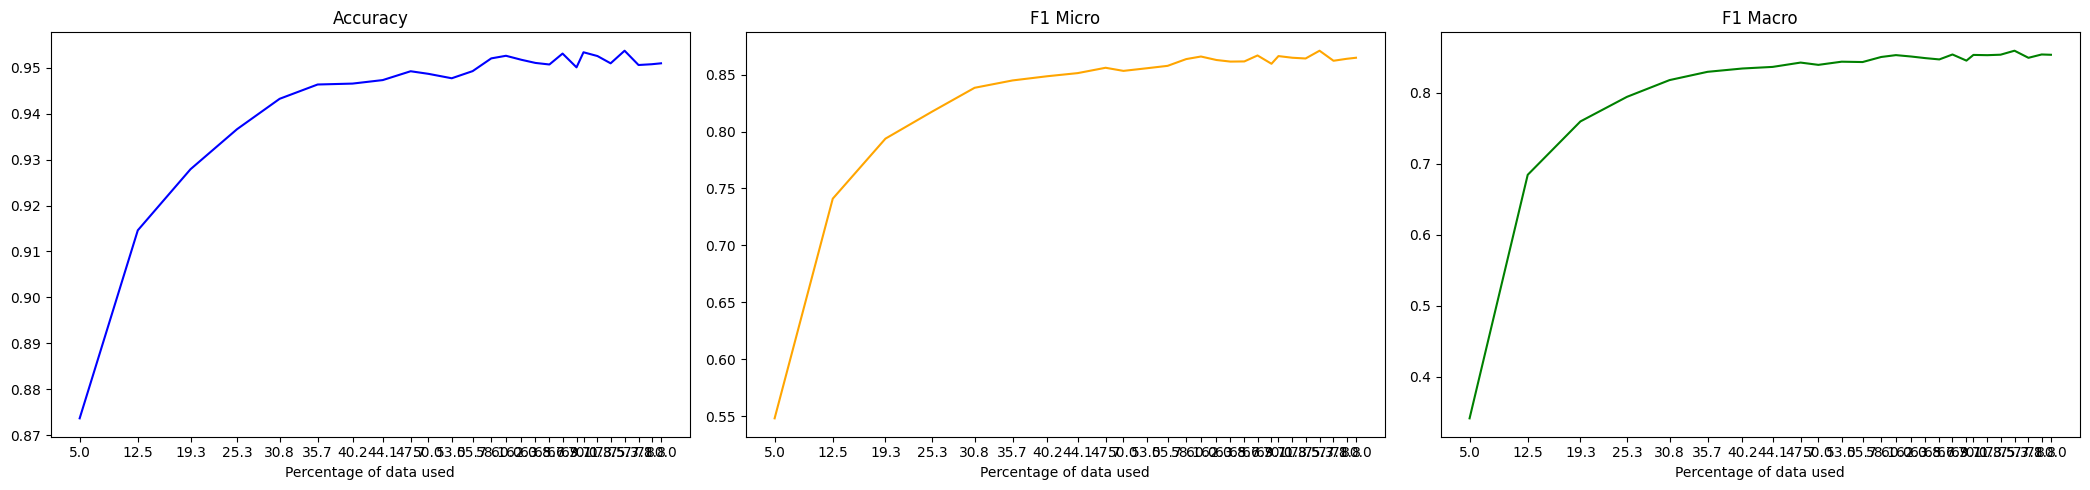

Result saved to results/hsd-mc-1-results.csv


In [ ]:
active_learning(42, 0, 'mc')

# KMEANS

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.651, Accuracy: 0.802, F1 Micro: 0.4002, F1 Macro: 0.1143
Epoch 2/10, Train Loss: 0.4865, Accuracy: 0.8303, F1 Micro: 0.1548, F1 Macro: 0.0486
Epoch 3/10, Train Loss: 0.4284, Accuracy: 0.8298, F1 Micro: 0.1357, F1 Macro: 0.0475
Epoch 4/10, Train Loss: 0.4021, Accuracy: 0.8325, F1 Micro: 0.166, F1 Macro: 0.0558
Epoch 5/10, Train Loss: 0.392, Accuracy: 0.8478, F1 Micro: 0.352, F1 Macro: 0.1202
Epoch 6/10, Train Loss: 0.3906, Accuracy: 0.8493, F1 Micro: 0.3887, F1 Macro: 0.1458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3595, Accuracy: 0.8523, F1 Micro: 0.413, F1 Macro: 0.1775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3511, Accuracy: 0.8584, F1 Micro: 0.4489, F1 Macro: 0.2282
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3248, Accuracy: 0.8663, F1 Micro: 0.5084, F1 Macro: 0.2815
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2992, Accuracy: 0.8736, F1 Micro: 0.548, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5486, Accuracy: 0.8246, F1 Micro: 0.0666, F1 Macro: 0.0243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4226, Accuracy: 0.8327, F1 Micro: 0.1645, F1 Macro: 0.0548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3975, Accuracy: 0.8506, F1 Micro: 0.3812, F1 Macro: 0.1425
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3688, Accuracy: 0.8635, F1 Micro: 0.4642, F1 Macro: 0.2336
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3322, Accuracy: 0.8732, F1 Micro: 0.5131, F1 Macro: 0.3097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2858, Accuracy: 0.8873, F1 Micro: 0.6129, F1 Macro: 0.4756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2567, Accuracy: 0.8978, F1 Micro: 0.6916, F1 Macro: 0.5985
Epoch 8/10, Train Loss: 0.226, Accuracy: 0.8996, F1 Micro: 0.6672, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1991, Accuracy: 0.907, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5078, Accuracy: 0.827, F1 Micro: 0.0956, F1 Macro: 0.0336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3988, Accuracy: 0.8503, F1 Micro: 0.3925, F1 Macro: 0.1411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3571, Accuracy: 0.8699, F1 Micro: 0.5112, F1 Macro: 0.2437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3064, Accuracy: 0.8921, F1 Micro: 0.6342, F1 Macro: 0.4849
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2577, Accuracy: 0.8987, F1 Micro: 0.6605, F1 Macro: 0.5683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2274, Accuracy: 0.9114, F1 Micro: 0.7289, F1 Macro: 0.6589
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1895, Accuracy: 0.9166, F1 Micro: 0.745, F1 Macro: 0.6894
Epoch 8/10, Train Loss: 0.1592, Accuracy: 0.9176, F1 Micro: 0.7439, F1 Macro: 0.686
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.141, Accuracy: 0.9204, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.491, Accuracy: 0.8377, F1 Micro: 0.2139, F1 Macro: 0.0754
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3813, Accuracy: 0.862, F1 Micro: 0.4741, F1 Macro: 0.2165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3254, Accuracy: 0.8896, F1 Micro: 0.6146, F1 Macro: 0.4405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2666, Accuracy: 0.8999, F1 Micro: 0.6552, F1 Macro: 0.5515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2168, Accuracy: 0.9124, F1 Micro: 0.7282, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1864, Accuracy: 0.9193, F1 Micro: 0.754, F1 Macro: 0.6947
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1636, Accuracy: 0.9226, F1 Micro: 0.7709, F1 Macro: 0.7243
Epoch 8/10, Train Loss: 0.1422, Accuracy: 0.9226, F1 Micro: 0.7588, F1 Macro: 0.7149
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1193, Accuracy: 0.9255, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4771, Accuracy: 0.8454, F1 Micro: 0.364, F1 Macro: 0.1138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3721, Accuracy: 0.8683, F1 Micro: 0.475, F1 Macro: 0.2355
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3069, Accuracy: 0.8983, F1 Micro: 0.6723, F1 Macro: 0.5564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.247, Accuracy: 0.9106, F1 Micro: 0.7225, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.206, Accuracy: 0.9171, F1 Micro: 0.7357, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1704, Accuracy: 0.9231, F1 Micro: 0.777, F1 Macro: 0.7337
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1416, Accuracy: 0.926, F1 Micro: 0.7802, F1 Macro: 0.7375
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1255, Accuracy: 0.9293, F1 Micro: 0.7917, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0997, Accuracy: 0.9296, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4688, Accuracy: 0.8496, F1 Micro: 0.3979, F1 Macro: 0.1452
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3641, Accuracy: 0.8848, F1 Micro: 0.6044, F1 Macro: 0.4061
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2848, Accuracy: 0.9074, F1 Micro: 0.7017, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2302, Accuracy: 0.9209, F1 Micro: 0.7593, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1881, Accuracy: 0.9251, F1 Micro: 0.7672, F1 Macro: 0.7161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1575, Accuracy: 0.9302, F1 Micro: 0.7856, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1352, Accuracy: 0.9327, F1 Micro: 0.7997, F1 Macro: 0.7618
Epoch 8/10, Train Loss: 0.1075, Accuracy: 0.9316, F1 Micro: 0.7978, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0944, Accuracy: 0.9327, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4675, Accuracy: 0.8511, F1 Micro: 0.4027, F1 Macro: 0.1514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3464, Accuracy: 0.8905, F1 Micro: 0.6213, F1 Macro: 0.4191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2648, Accuracy: 0.9145, F1 Micro: 0.7368, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2197, Accuracy: 0.924, F1 Micro: 0.7677, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.9303, F1 Micro: 0.7962, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9316, F1 Micro: 0.8016, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1245, Accuracy: 0.9341, F1 Micro: 0.8123, F1 Macro: 0.784
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1035, Accuracy: 0.9354, F1 Micro: 0.815, F1 Macro: 0.7873
Epoch 9/10, Train Loss: 0.0909, Accuracy: 0.9348, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4574, Accuracy: 0.8542, F1 Micro: 0.4211, F1 Macro: 0.1552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.337, Accuracy: 0.8881, F1 Micro: 0.5938, F1 Macro: 0.4232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2638, Accuracy: 0.9179, F1 Micro: 0.7634, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2108, Accuracy: 0.9267, F1 Micro: 0.7775, F1 Macro: 0.7321
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1713, Accuracy: 0.9324, F1 Micro: 0.8062, F1 Macro: 0.7675
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9336, F1 Micro: 0.8009, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1205, Accuracy: 0.9378, F1 Micro: 0.8204, F1 Macro: 0.7851
Epoch 8/10, Train Loss: 0.1029, Accuracy: 0.938, F1 Micro: 0.8131, F1 Macro: 0.7834
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9411, F1 Micro: 0.8304, F1 Macro: 0.8053
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4467, Accuracy: 0.8597, F1 Micro: 0.4465, F1 Macro: 0.1996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3261, Accuracy: 0.9021, F1 Micro: 0.6952, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2542, Accuracy: 0.9158, F1 Micro: 0.7344, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.203, Accuracy: 0.9281, F1 Micro: 0.7983, F1 Macro: 0.7582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.934, F1 Micro: 0.8061, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9369, F1 Micro: 0.8148, F1 Macro: 0.7845
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.937, F1 Micro: 0.8225, F1 Macro: 0.7965
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9373, F1 Micro: 0.8266, F1 Macro: 0.8002
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4481, Accuracy: 0.8635, F1 Micro: 0.4646, F1 Macro: 0.2015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3172, Accuracy: 0.9065, F1 Micro: 0.7211, F1 Macro: 0.631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2513, Accuracy: 0.9225, F1 Micro: 0.7593, F1 Macro: 0.7093
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9313, F1 Micro: 0.8039, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9378, F1 Micro: 0.8181, F1 Macro: 0.784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9384, F1 Micro: 0.8215, F1 Macro: 0.7942
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9389, F1 Micro: 0.8282, F1 Macro: 0.8021
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9422, F1 Micro: 0.8354, F1 Macro: 0.8149
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9412, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4443, Accuracy: 0.867, F1 Micro: 0.4895, F1 Macro: 0.2443
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3108, Accuracy: 0.9069, F1 Micro: 0.7115, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2394, Accuracy: 0.9256, F1 Micro: 0.7846, F1 Macro: 0.7412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1958, Accuracy: 0.9311, F1 Micro: 0.7918, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9339, F1 Micro: 0.8189, F1 Macro: 0.7904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1311, Accuracy: 0.9405, F1 Micro: 0.8231, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9403, F1 Micro: 0.8347, F1 Macro: 0.8123
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9419, F1 Micro: 0.8391, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.438, Accuracy: 0.8715, F1 Micro: 0.5148, F1 Macro: 0.2651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3058, Accuracy: 0.9105, F1 Micro: 0.7193, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.233, Accuracy: 0.9266, F1 Micro: 0.7873, F1 Macro: 0.7412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9332, F1 Micro: 0.8057, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.9388, F1 Micro: 0.8254, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.9423, F1 Micro: 0.8326, F1 Macro: 0.8064
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9429, F1 Micro: 0.8406, F1 Macro: 0.8193
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9452, F1 Micro: 0.844, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4355, Accuracy: 0.8759, F1 Micro: 0.5523, F1 Macro: 0.3216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2951, Accuracy: 0.9088, F1 Micro: 0.7, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2265, Accuracy: 0.929, F1 Micro: 0.787, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9345, F1 Micro: 0.8047, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.9387, F1 Micro: 0.8143, F1 Macro: 0.79
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9409, F1 Micro: 0.826, F1 Macro: 0.8058
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9444, F1 Micro: 0.841, F1 Macro: 0.8219
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9458, F1 Micro: 0.8427, F1 Macro: 0.8262
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0734, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4284, Accuracy: 0.8772, F1 Micro: 0.5726, F1 Macro: 0.3401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2903, Accuracy: 0.9162, F1 Micro: 0.7422, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2266, Accuracy: 0.9301, F1 Micro: 0.795, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1828, Accuracy: 0.9314, F1 Micro: 0.8118, F1 Macro: 0.783
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9383, F1 Micro: 0.8157, F1 Macro: 0.788
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.943, F1 Micro: 0.8372, F1 Macro: 0.8143
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9453, F1 Micro: 0.8452, F1 Macro: 0.8222
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9456, F1 Micro: 0.8486, F1 Macro: 0.8325
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4287, Accuracy: 0.8764, F1 Micro: 0.539, F1 Macro: 0.3207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2883, Accuracy: 0.9175, F1 Micro: 0.7545, F1 Macro: 0.6975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9289, F1 Micro: 0.7939, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9372, F1 Micro: 0.8149, F1 Macro: 0.7847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.9433, F1 Micro: 0.8368, F1 Macro: 0.8071
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9444, F1 Micro: 0.8421, F1 Macro: 0.8217
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.944, F1 Micro: 0.8443, F1 Macro: 0.8263
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9444, F1 Micro: 0.847, F1 Macro: 0.8287
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4267, Accuracy: 0.8794, F1 Micro: 0.5728, F1 Macro: 0.3457
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2885, Accuracy: 0.9173, F1 Micro: 0.741, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2168, Accuracy: 0.9309, F1 Micro: 0.796, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9384, F1 Micro: 0.8247, F1 Macro: 0.7927
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9428, F1 Micro: 0.8347, F1 Macro: 0.8116
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.942, F1 Micro: 0.8384, F1 Macro: 0.8155
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.9478, F1 Micro: 0.8517, F1 Macro: 0.8297
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9464, F1 Micro: 0.8511, F1 Macro: 0.8342
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9477, F1 Micro: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4231, Accuracy: 0.8824, F1 Micro: 0.584, F1 Macro: 0.385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.9201, F1 Micro: 0.7726, F1 Macro: 0.7279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9292, F1 Micro: 0.8061, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9387, F1 Micro: 0.8282, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9416, F1 Micro: 0.8305, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1115, Accuracy: 0.9457, F1 Micro: 0.8455, F1 Macro: 0.8251
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9478, F1 Micro: 0.8515, F1 Macro: 0.8375
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9492, F1 Micro: 0.8543, F1 Macro: 0.8383
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4213, Accuracy: 0.8839, F1 Micro: 0.6127, F1 Macro: 0.4468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2765, Accuracy: 0.9213, F1 Micro: 0.7678, F1 Macro: 0.7205
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.9321, F1 Micro: 0.7934, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9404, F1 Micro: 0.8277, F1 Macro: 0.7979
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9436, F1 Micro: 0.8409, F1 Macro: 0.8174
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.9463, F1 Micro: 0.8417, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9481, F1 Micro: 0.8538, F1 Macro: 0.8366
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.9483, F1 Micro: 0.8546, F1 Macro: 0.8351
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4206, Accuracy: 0.8868, F1 Micro: 0.6208, F1 Macro: 0.4272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2745, Accuracy: 0.9168, F1 Micro: 0.7299, F1 Macro: 0.6614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9317, F1 Micro: 0.8109, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9406, F1 Micro: 0.8251, F1 Macro: 0.7942
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9413, F1 Micro: 0.8366, F1 Macro: 0.8142
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9459, F1 Micro: 0.8463, F1 Macro: 0.8261
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9487, F1 Micro: 0.8503, F1 Macro: 0.8345
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9446, F1 Micro: 0.8492, F1 Macro: 0.835
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9505, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4132, Accuracy: 0.8824, F1 Micro: 0.5786, F1 Macro: 0.3943
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.9232, F1 Micro: 0.7689, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.936, F1 Micro: 0.8073, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9379, F1 Micro: 0.8274, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9442, F1 Micro: 0.8399, F1 Macro: 0.8153
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.9432, F1 Micro: 0.8407, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9493, F1 Micro: 0.8556, F1 Macro: 0.8379
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9496, F1 Micro: 0.8575, F1 Macro: 0.8425
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4144, Accuracy: 0.8794, F1 Micro: 0.5469, F1 Macro: 0.3734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2727, Accuracy: 0.9215, F1 Micro: 0.7618, F1 Macro: 0.6877
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2016, Accuracy: 0.9349, F1 Micro: 0.8124, F1 Macro: 0.7798
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9391, F1 Micro: 0.8305, F1 Macro: 0.8034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9389, F1 Micro: 0.8345, F1 Macro: 0.8105
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1069, Accuracy: 0.9475, F1 Micro: 0.8531, F1 Macro: 0.8326
Epoch 7/10, Train Loss: 0.0894, Accuracy: 0.9469, F1 Micro: 0.8524, F1 Macro: 0.8361
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.949, F1 Micro: 0.8569, F1 Macro: 0.8418
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9502, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4083, Accuracy: 0.8898, F1 Micro: 0.6433, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2592, Accuracy: 0.922, F1 Micro: 0.7667, F1 Macro: 0.7114
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9357, F1 Micro: 0.8127, F1 Macro: 0.7806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9392, F1 Micro: 0.8231, F1 Macro: 0.7932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9464, F1 Micro: 0.8438, F1 Macro: 0.82
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9469, F1 Micro: 0.8509, F1 Macro: 0.8314
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9475, F1 Micro: 0.8534, F1 Macro: 0.8355
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9508, F1 Micro: 0.8598, F1 Macro: 0.8453
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4067, Accuracy: 0.8885, F1 Micro: 0.6268, F1 Macro: 0.4818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.9233, F1 Micro: 0.7683, F1 Macro: 0.7046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9341, F1 Micro: 0.8082, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9368, F1 Micro: 0.8235, F1 Macro: 0.7902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9434, F1 Micro: 0.8432, F1 Macro: 0.8197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9451, F1 Micro: 0.8474, F1 Macro: 0.8288
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9486, F1 Micro: 0.8536, F1 Macro: 0.8352
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9485, F1 Micro: 0.8566, F1 Macro: 0.8398
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3984, Accuracy: 0.8904, F1 Micro: 0.6251, F1 Macro: 0.471
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2526, Accuracy: 0.9253, F1 Micro: 0.7754, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1903, Accuracy: 0.9341, F1 Micro: 0.8001, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9429, F1 Micro: 0.8344, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9427, F1 Micro: 0.8413, F1 Macro: 0.8131
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9478, F1 Micro: 0.8525, F1 Macro: 0.8311
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9508, F1 Micro: 0.8592, F1 Macro: 0.8439
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0692, Accuracy: 0.9511, F1 Micro: 0.8626, F1 Macro: 0.8468
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3975, Accuracy: 0.8933, F1 Micro: 0.649, F1 Macro: 0.4964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.9218, F1 Micro: 0.7793, F1 Macro: 0.7317
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.9367, F1 Micro: 0.8122, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9395, F1 Micro: 0.8303, F1 Macro: 0.8031
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9453, F1 Micro: 0.8442, F1 Macro: 0.8176
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9413, F1 Micro: 0.8416, F1 Macro: 0.8207
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.9498, F1 Micro: 0.8569, F1 Macro: 0.8374
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.951, F1 Micro: 0.8617, F1 Macro: 0.8475
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9531, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3871, Accuracy: 0.8912, F1 Micro: 0.6266, F1 Macro: 0.4846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.9268, F1 Micro: 0.7773, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9358, F1 Micro: 0.8165, F1 Macro: 0.7854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1435, Accuracy: 0.941, F1 Micro: 0.8341, F1 Macro: 0.8055
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9444, F1 Micro: 0.8417, F1 Macro: 0.8184
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9447, F1 Micro: 0.8453, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9477, F1 Micro: 0.8534, F1 Macro: 0.8375
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0684, Accuracy: 0.9511, F1 Micro: 0.8615, F1 Macro: 0.8461
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9467, F1 Micro: 

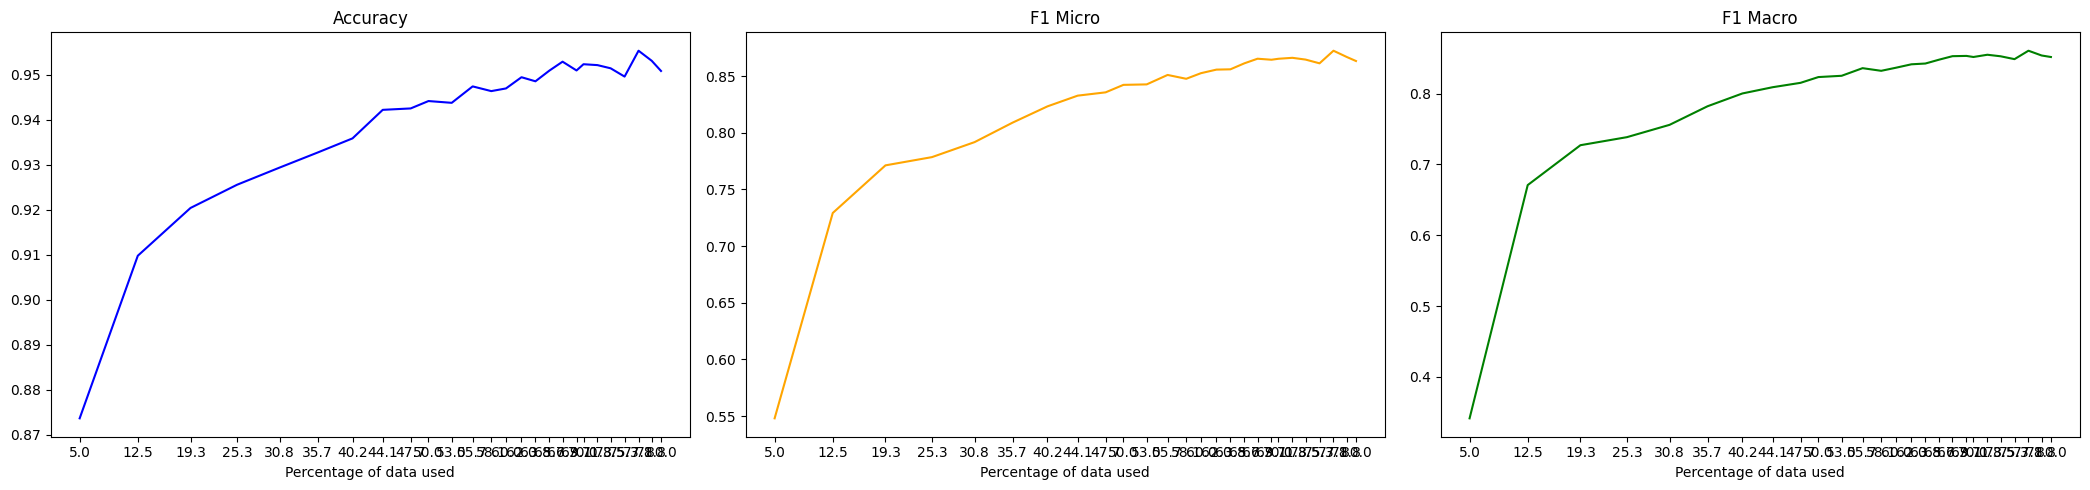

Result saved to results/hsd-kmeans-1-results.csv


In [29]:
active_learning(42, 0, 'kmeans')

# CORESET

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.651, Accuracy: 0.802, F1 Micro: 0.4002, F1 Macro: 0.1143
Epoch 2/10, Train Loss: 0.4865, Accuracy: 0.8303, F1 Micro: 0.1548, F1 Macro: 0.0486
Epoch 3/10, Train Loss: 0.4284, Accuracy: 0.8298, F1 Micro: 0.1357, F1 Macro: 0.0475
Epoch 4/10, Train Loss: 0.4021, Accuracy: 0.8325, F1 Micro: 0.166, F1 Macro: 0.0558
Epoch 5/10, Train Loss: 0.392, Accuracy: 0.8478, F1 Micro: 0.352, F1 Macro: 0.1202
Epoch 6/10, Train Loss: 0.3906, Accuracy: 0.8493, F1 Micro: 0.3887, F1 Macro: 0.1458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3595, Accuracy: 0.8523, F1 Micro: 0.413, F1 Macro: 0.1775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3511, Accuracy: 0.8584, F1 Micro: 0.4489, F1 Macro: 0.2282
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3248, Accuracy: 0.8663, F1 Micro: 0.5084, F1 Macro: 0.2815
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2992, Accuracy: 0.8736, F1 Micro: 0.548, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.581, Accuracy: 0.8073, F1 Micro: 0.3661, F1 Macro: 0.1463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4495, Accuracy: 0.8295, F1 Micro: 0.4776, F1 Macro: 0.2585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3885, Accuracy: 0.8505, F1 Micro: 0.5198, F1 Macro: 0.338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3475, Accuracy: 0.8697, F1 Micro: 0.5663, F1 Macro: 0.4095
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3076, Accuracy: 0.8821, F1 Micro: 0.5873, F1 Macro: 0.4595
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2764, Accuracy: 0.8883, F1 Micro: 0.6563, F1 Macro: 0.5389
Epoch 7/10, Train Loss: 0.2481, Accuracy: 0.8938, F1 Micro: 0.6458, F1 Macro: 0.5444
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2189, Accuracy: 0.8986, F1 Micro: 0.6775, F1 Macro: 0.5952
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2037, Accuracy: 0.9024, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.8246, F1 Micro: 0.4452, F1 Macro: 0.2092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3946, Accuracy: 0.8576, F1 Micro: 0.536, F1 Macro: 0.3331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3264, Accuracy: 0.8811, F1 Micro: 0.6297, F1 Macro: 0.5016
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2777, Accuracy: 0.8949, F1 Micro: 0.6531, F1 Macro: 0.5603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2345, Accuracy: 0.9021, F1 Micro: 0.709, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2101, Accuracy: 0.9109, F1 Micro: 0.7284, F1 Macro: 0.6687
Epoch 7/10, Train Loss: 0.1806, Accuracy: 0.9122, F1 Micro: 0.7222, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1617, Accuracy: 0.9167, F1 Micro: 0.7523, F1 Macro: 0.7027
Epoch 9/10, Train Loss: 0.1351, Accuracy: 0.9142, F1 Micro: 0.733, F1 Macro: 0.6878
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5032, Accuracy: 0.8369, F1 Micro: 0.4521, F1 Macro: 0.2305
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3618, Accuracy: 0.8796, F1 Micro: 0.5949, F1 Macro: 0.4482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2854, Accuracy: 0.8939, F1 Micro: 0.6627, F1 Macro: 0.564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2378, Accuracy: 0.9049, F1 Micro: 0.7005, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1996, Accuracy: 0.9062, F1 Micro: 0.7211, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1705, Accuracy: 0.9142, F1 Micro: 0.7331, F1 Macro: 0.6883
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1436, Accuracy: 0.9172, F1 Micro: 0.7504, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1248, Accuracy: 0.9195, F1 Micro: 0.7544, F1 Macro: 0.7167
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5047, Accuracy: 0.8405, F1 Micro: 0.4935, F1 Macro: 0.2791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3597, Accuracy: 0.8886, F1 Micro: 0.6764, F1 Macro: 0.5865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.9077, F1 Micro: 0.7066, F1 Macro: 0.6472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2202, Accuracy: 0.9149, F1 Micro: 0.7315, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1832, Accuracy: 0.9206, F1 Micro: 0.7565, F1 Macro: 0.7161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9236, F1 Micro: 0.7681, F1 Macro: 0.732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1287, Accuracy: 0.925, F1 Micro: 0.7801, F1 Macro: 0.7482
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.9264, F1 Micro: 0.7751, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0963, Accuracy: 0.9261, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4834, Accuracy: 0.8487, F1 Micro: 0.5208, F1 Macro: 0.3073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.328, Accuracy: 0.9004, F1 Micro: 0.6938, F1 Macro: 0.6032
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2548, Accuracy: 0.9097, F1 Micro: 0.7442, F1 Macro: 0.69
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2057, Accuracy: 0.9203, F1 Micro: 0.7629, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.172, Accuracy: 0.9212, F1 Micro: 0.7746, F1 Macro: 0.7358
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9248, F1 Micro: 0.7724, F1 Macro: 0.7392
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9272, F1 Micro: 0.7782, F1 Macro: 0.7457
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9272, F1 Micro: 0.7796, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0869, Accuracy: 0.9284, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4762, Accuracy: 0.8609, F1 Micro: 0.5405, F1 Macro: 0.3436
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3265, Accuracy: 0.9038, F1 Micro: 0.6987, F1 Macro: 0.6139
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2538, Accuracy: 0.9165, F1 Micro: 0.7629, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2019, Accuracy: 0.9241, F1 Micro: 0.7757, F1 Macro: 0.7383
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1662, Accuracy: 0.9286, F1 Micro: 0.7858, F1 Macro: 0.752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.138, Accuracy: 0.9331, F1 Micro: 0.7985, F1 Macro: 0.7708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9333, F1 Micro: 0.8038, F1 Macro: 0.7805
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9337, F1 Micro: 0.7997, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9338, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4612, Accuracy: 0.8573, F1 Micro: 0.5479, F1 Macro: 0.3471
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3081, Accuracy: 0.905, F1 Micro: 0.7101, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2298, Accuracy: 0.9162, F1 Micro: 0.7331, F1 Macro: 0.6705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1867, Accuracy: 0.9286, F1 Micro: 0.7826, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9305, F1 Micro: 0.7989, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9324, F1 Micro: 0.8044, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.9356, F1 Micro: 0.8097, F1 Macro: 0.7849
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9353, F1 Micro: 0.8155, F1 Macro: 0.7923
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4586, Accuracy: 0.8687, F1 Micro: 0.5658, F1 Macro: 0.3711
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3083, Accuracy: 0.9108, F1 Micro: 0.7304, F1 Macro: 0.6583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2328, Accuracy: 0.9224, F1 Micro: 0.7711, F1 Macro: 0.7322
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9277, F1 Micro: 0.7891, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.9314, F1 Micro: 0.8005, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9357, F1 Micro: 0.811, F1 Macro: 0.7855
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9367, F1 Micro: 0.8151, F1 Macro: 0.7932
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9368, F1 Micro: 0.8144, F1 Macro: 0.7963
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9366, F1 Micro: 0.8097, F1 Macro: 0.7934
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4505, Accuracy: 0.8735, F1 Micro: 0.5688, F1 Macro: 0.3649
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2964, Accuracy: 0.9132, F1 Micro: 0.7323, F1 Macro: 0.6614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2264, Accuracy: 0.9241, F1 Micro: 0.765, F1 Macro: 0.7176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9296, F1 Micro: 0.7819, F1 Macro: 0.7478
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9318, F1 Micro: 0.8115, F1 Macro: 0.7812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9366, F1 Micro: 0.8184, F1 Macro: 0.7937
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9395, F1 Micro: 0.8239, F1 Macro: 0.8001
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9402, F1 Micro: 0.8276, F1 Macro: 0.8076
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4403, Accuracy: 0.8776, F1 Micro: 0.5892, F1 Macro: 0.4093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2834, Accuracy: 0.9114, F1 Micro: 0.7255, F1 Macro: 0.6583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.9239, F1 Micro: 0.7802, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9299, F1 Micro: 0.7972, F1 Macro: 0.7631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9342, F1 Micro: 0.8107, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9383, F1 Micro: 0.8123, F1 Macro: 0.7853
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9395, F1 Micro: 0.8252, F1 Macro: 0.8039
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9322, F1 Micro: 0.8167, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9399, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4385, Accuracy: 0.8798, F1 Micro: 0.5692, F1 Macro: 0.4019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2814, Accuracy: 0.9106, F1 Micro: 0.7414, F1 Macro: 0.6814
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.9276, F1 Micro: 0.7862, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9341, F1 Micro: 0.8083, F1 Macro: 0.7771
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9383, F1 Micro: 0.8093, F1 Macro: 0.7846
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9391, F1 Micro: 0.8236, F1 Macro: 0.7994
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.942, F1 Micro: 0.8352, F1 Macro: 0.8168
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.936, F1 Micro: 0.824, F1 Macro: 0.8052
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9417, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4291, Accuracy: 0.8862, F1 Micro: 0.6203, F1 Macro: 0.4756
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.9137, F1 Micro: 0.7591, F1 Macro: 0.7065
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9279, F1 Micro: 0.7828, F1 Macro: 0.7379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9335, F1 Micro: 0.8115, F1 Macro: 0.7808
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.9372, F1 Micro: 0.8213, F1 Macro: 0.7983
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9401, F1 Micro: 0.8297, F1 Macro: 0.8079
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0894, Accuracy: 0.9431, F1 Micro: 0.8365, F1 Macro: 0.8174
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9432, F1 Micro: 0.8376, F1 Macro: 0.8198
Epoch 9/10, Train Loss: 0.0668, Accuracy: 0.9411, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4321, Accuracy: 0.8852, F1 Micro: 0.6397, F1 Macro: 0.4837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2743, Accuracy: 0.9176, F1 Micro: 0.7388, F1 Macro: 0.6696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2089, Accuracy: 0.9306, F1 Micro: 0.79, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.932, F1 Micro: 0.8097, F1 Macro: 0.7808
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.9333, F1 Micro: 0.8195, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9416, F1 Micro: 0.8238, F1 Macro: 0.8036
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9415, F1 Micro: 0.8354, F1 Macro: 0.8185
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9434, F1 Micro: 0.8387, F1 Macro: 0.8247
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.423, Accuracy: 0.885, F1 Micro: 0.6537, F1 Macro: 0.5175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.9184, F1 Micro: 0.7684, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9251, F1 Micro: 0.7939, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9331, F1 Micro: 0.8123, F1 Macro: 0.7838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9384, F1 Micro: 0.8263, F1 Macro: 0.8023
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9393, F1 Micro: 0.8314, F1 Macro: 0.8102
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.9426, F1 Micro: 0.8387, F1 Macro: 0.8213
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9437, F1 Micro: 0.8414, F1 Macro: 0.828
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4247, Accuracy: 0.8897, F1 Micro: 0.6348, F1 Macro: 0.4969
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.9198, F1 Micro: 0.7633, F1 Macro: 0.7072
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9307, F1 Micro: 0.7993, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.9388, F1 Micro: 0.8201, F1 Macro: 0.7921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.9415, F1 Micro: 0.8327, F1 Macro: 0.8083
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9439, F1 Micro: 0.8412, F1 Macro: 0.8203
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9472, F1 Micro: 0.8495, F1 Macro: 0.8325
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9459, F1 Micro: 0.8474, F1 Macro: 0.8331
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9468, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.415, Accuracy: 0.8883, F1 Micro: 0.6377, F1 Macro: 0.4862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.9217, F1 Micro: 0.7619, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9331, F1 Micro: 0.8049, F1 Macro: 0.7707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9361, F1 Micro: 0.8221, F1 Macro: 0.795
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9428, F1 Micro: 0.8328, F1 Macro: 0.8096
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9436, F1 Micro: 0.8405, F1 Macro: 0.8196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.946, F1 Micro: 0.8486, F1 Macro: 0.8341
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9462, F1 Micro: 0.8496, F1 Macro: 0.8339
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4153, Accuracy: 0.8911, F1 Micro: 0.6447, F1 Macro: 0.4978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.9241, F1 Micro: 0.7755, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.197, Accuracy: 0.934, F1 Micro: 0.8082, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9385, F1 Micro: 0.824, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9383, F1 Micro: 0.8292, F1 Macro: 0.8044
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9434, F1 Micro: 0.8419, F1 Macro: 0.8225
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9482, F1 Micro: 0.851, F1 Macro: 0.8333
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9403, F1 Micro: 0.8398, F1 Macro: 0.8249
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9502, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4095, Accuracy: 0.8904, F1 Micro: 0.6531, F1 Macro: 0.5136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2555, Accuracy: 0.9239, F1 Micro: 0.7779, F1 Macro: 0.7271
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9354, F1 Micro: 0.8131, F1 Macro: 0.7808
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9401, F1 Micro: 0.8246, F1 Macro: 0.7927
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9448, F1 Micro: 0.8402, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9422, F1 Micro: 0.8405, F1 Macro: 0.8212
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9439, F1 Micro: 0.8447, F1 Macro: 0.8272
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9478, F1 Micro: 0.8503, F1 Macro: 0.834
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4127, Accuracy: 0.8929, F1 Micro: 0.6481, F1 Macro: 0.5093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2557, Accuracy: 0.9198, F1 Micro: 0.7756, F1 Macro: 0.7327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1941, Accuracy: 0.9331, F1 Micro: 0.8137, F1 Macro: 0.7824
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9389, F1 Micro: 0.8276, F1 Macro: 0.8037
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9439, F1 Micro: 0.8384, F1 Macro: 0.8176
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9448, F1 Micro: 0.8443, F1 Macro: 0.8254
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9468, F1 Micro: 0.8495, F1 Macro: 0.8337
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9481, F1 Micro: 0.8541, F1 Macro: 0.8409
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4055, Accuracy: 0.8935, F1 Micro: 0.6515, F1 Macro: 0.5155
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.9239, F1 Micro: 0.773, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9348, F1 Micro: 0.805, F1 Macro: 0.7731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9398, F1 Micro: 0.828, F1 Macro: 0.8013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9441, F1 Micro: 0.8386, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9465, F1 Micro: 0.8476, F1 Macro: 0.829
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9459, F1 Micro: 0.8471, F1 Macro: 0.8294
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9496, F1 Micro: 0.8557, F1 Macro: 0.8438
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9494, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.403, Accuracy: 0.8913, F1 Micro: 0.6392, F1 Macro: 0.4943
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.9227, F1 Micro: 0.7743, F1 Macro: 0.7264
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9356, F1 Micro: 0.8087, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9398, F1 Micro: 0.8255, F1 Macro: 0.7979
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.944, F1 Micro: 0.8409, F1 Macro: 0.8173
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9451, F1 Micro: 0.8453, F1 Macro: 0.8272
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9489, F1 Micro: 0.8534, F1 Macro: 0.8357
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9462, F1 Micro: 0.8503, F1 Macro: 0.8368
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9481, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4014, Accuracy: 0.8885, F1 Micro: 0.6047, F1 Macro: 0.4527
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.9229, F1 Micro: 0.7579, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9362, F1 Micro: 0.8152, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9406, F1 Micro: 0.83, F1 Macro: 0.799
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9448, F1 Micro: 0.8424, F1 Macro: 0.8198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.948, F1 Micro: 0.8504, F1 Macro: 0.8322
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9486, F1 Micro: 0.8491, F1 Macro: 0.8316
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9476, F1 Micro: 0.8547, F1 Macro: 0.8397
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9506, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.393, Accuracy: 0.8949, F1 Micro: 0.6546, F1 Macro: 0.5116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9253, F1 Micro: 0.7742, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.935, F1 Micro: 0.8092, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.9421, F1 Micro: 0.8324, F1 Macro: 0.8023
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9439, F1 Micro: 0.8431, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9453, F1 Micro: 0.8467, F1 Macro: 0.8268
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9459, F1 Micro: 0.8493, F1 Macro: 0.8326
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.946, F1 Micro: 0.8491, F1 Macro: 0.8311
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9497, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3912, Accuracy: 0.8942, F1 Micro: 0.6661, F1 Macro: 0.5472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.9231, F1 Micro: 0.765, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.9357, F1 Micro: 0.8018, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9433, F1 Micro: 0.8358, F1 Macro: 0.8082
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9448, F1 Micro: 0.8456, F1 Macro: 0.8212
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.949, F1 Micro: 0.8544, F1 Macro: 0.8345
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9487, F1 Micro: 0.8572, F1 Macro: 0.8356
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9509, F1 Micro: 0.8608, F1 Macro: 0.8469
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.89, F1 Micro: 0.6171, F1 Macro: 0.4596
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.9248, F1 Micro: 0.7705, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1847, Accuracy: 0.9356, F1 Micro: 0.8122, F1 Macro: 0.7748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9391, F1 Micro: 0.8306, F1 Macro: 0.8042
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9431, F1 Micro: 0.8425, F1 Macro: 0.8195
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9471, F1 Micro: 0.8519, F1 Macro: 0.8312
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9494, F1 Micro: 0.8562, F1 Macro: 0.8381
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9503, F1 Micro: 0.8617, F1 Macro: 0.8476
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.05

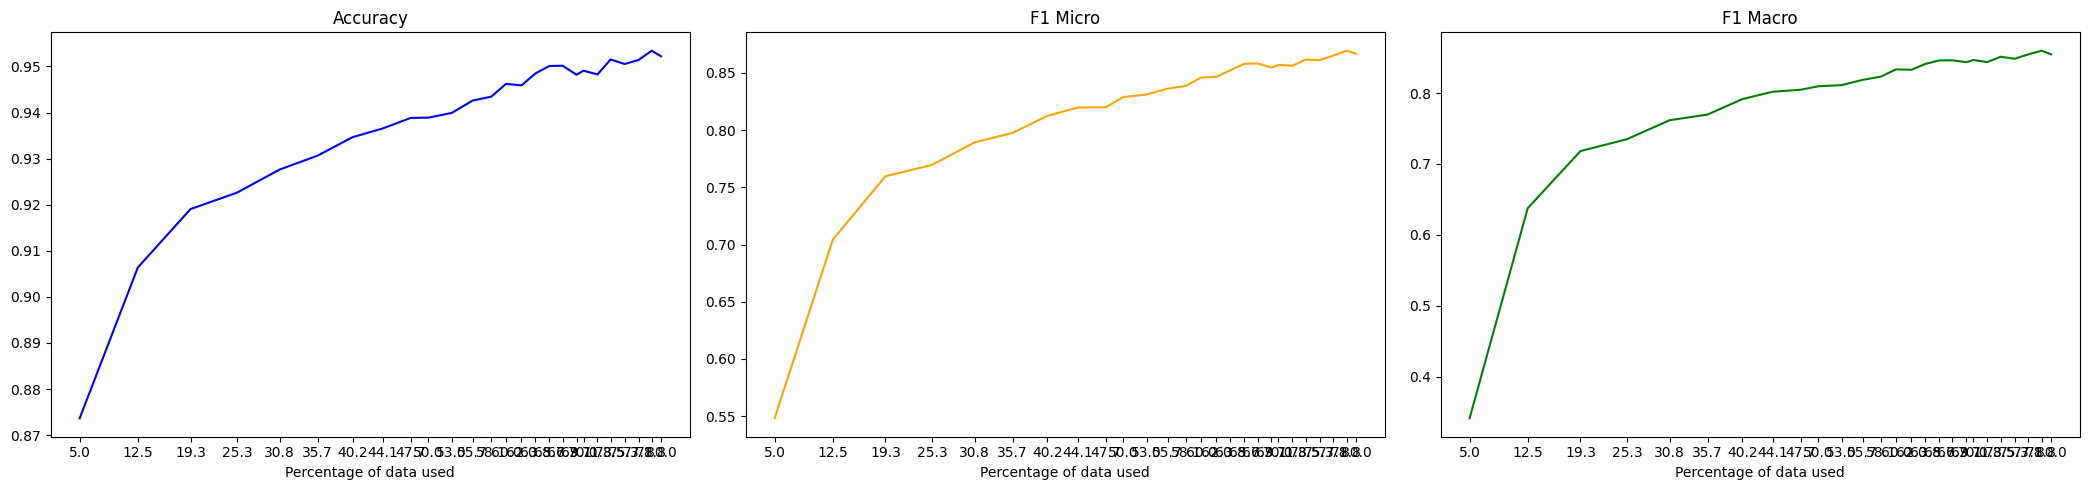

Result saved to results/hsd-coreset-1-results.csv


In [30]:
active_learning(42, 0, 'coreset')

# RANDOM SAMPLING

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.651, Accuracy: 0.802, F1 Micro: 0.4002, F1 Macro: 0.1143
Epoch 2/10, Train Loss: 0.4865, Accuracy: 0.8303, F1 Micro: 0.1548, F1 Macro: 0.0486
Epoch 3/10, Train Loss: 0.4284, Accuracy: 0.8298, F1 Micro: 0.1357, F1 Macro: 0.0475
Epoch 4/10, Train Loss: 0.4021, Accuracy: 0.8325, F1 Micro: 0.166, F1 Macro: 0.0558
Epoch 5/10, Train Loss: 0.392, Accuracy: 0.8478, F1 Micro: 0.352, F1 Macro: 0.1202
Epoch 6/10, Train Loss: 0.3906, Accuracy: 0.8493, F1 Micro: 0.3887, F1 Macro: 0.1458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3595, Accuracy: 0.8523, F1 Micro: 0.413, F1 Macro: 0.1775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3511, Accuracy: 0.8584, F1 Micro: 0.4489, F1 Macro: 0.2282
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3248, Accuracy: 0.8663, F1 Micro: 0.5084, F1 Macro: 0.2815
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2992, Accuracy: 0.8736, F1 Micro: 0.548, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5521, Accuracy: 0.8286, F1 Micro: 0.1276, F1 Macro: 0.0416
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4188, Accuracy: 0.846, F1 Micro: 0.3455, F1 Macro: 0.1078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3841, Accuracy: 0.8524, F1 Micro: 0.4167, F1 Macro: 0.1807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3564, Accuracy: 0.8679, F1 Micro: 0.5059, F1 Macro: 0.2787
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3126, Accuracy: 0.8825, F1 Micro: 0.6063, F1 Macro: 0.4372
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2856, Accuracy: 0.8899, F1 Micro: 0.6341, F1 Macro: 0.4988
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2464, Accuracy: 0.8973, F1 Micro: 0.671, F1 Macro: 0.5556
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2166, Accuracy: 0.9026, F1 Micro: 0.6987, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5097, Accuracy: 0.8366, F1 Micro: 0.2267, F1 Macro: 0.073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3837, Accuracy: 0.8527, F1 Micro: 0.4082, F1 Macro: 0.172
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3349, Accuracy: 0.8773, F1 Micro: 0.5645, F1 Macro: 0.3494
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2886, Accuracy: 0.8942, F1 Micro: 0.6609, F1 Macro: 0.5324
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2352, Accuracy: 0.904, F1 Micro: 0.7142, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2195, Accuracy: 0.9118, F1 Micro: 0.7391, F1 Macro: 0.6675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1858, Accuracy: 0.913, F1 Micro: 0.7544, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1598, Accuracy: 0.9178, F1 Micro: 0.7587, F1 Macro: 0.7033
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4889, Accuracy: 0.8384, F1 Micro: 0.2307, F1 Macro: 0.0786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3639, Accuracy: 0.87, F1 Micro: 0.5309, F1 Macro: 0.2999
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3026, Accuracy: 0.8914, F1 Micro: 0.6354, F1 Macro: 0.4959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2528, Accuracy: 0.9069, F1 Micro: 0.7073, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2122, Accuracy: 0.9138, F1 Micro: 0.7389, F1 Macro: 0.6669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1807, Accuracy: 0.9193, F1 Micro: 0.7537, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1529, Accuracy: 0.9225, F1 Micro: 0.7791, F1 Macro: 0.7339
Epoch 8/10, Train Loss: 0.1351, Accuracy: 0.9243, F1 Micro: 0.7766, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1142, Accuracy: 0.9262, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4687, Accuracy: 0.8483, F1 Micro: 0.37, F1 Macro: 0.1307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.345, Accuracy: 0.8799, F1 Micro: 0.5877, F1 Macro: 0.3954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2816, Accuracy: 0.9018, F1 Micro: 0.7083, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.231, Accuracy: 0.9129, F1 Micro: 0.743, F1 Macro: 0.6782
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1902, Accuracy: 0.9218, F1 Micro: 0.7702, F1 Macro: 0.7199
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1601, Accuracy: 0.9241, F1 Micro: 0.7733, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1362, Accuracy: 0.9282, F1 Micro: 0.7853, F1 Macro: 0.7494
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1172, Accuracy: 0.9269, F1 Micro: 0.797, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0988,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4652, Accuracy: 0.8514, F1 Micro: 0.4113, F1 Macro: 0.1828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3364, Accuracy: 0.8826, F1 Micro: 0.5842, F1 Macro: 0.3908
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2668, Accuracy: 0.9083, F1 Micro: 0.7191, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2173, Accuracy: 0.9199, F1 Micro: 0.7685, F1 Macro: 0.7109
Epoch 5/10, Train Loss: 0.1751, Accuracy: 0.9234, F1 Micro: 0.7628, F1 Macro: 0.7035
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1505, Accuracy: 0.9295, F1 Micro: 0.7926, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.9305, F1 Micro: 0.7957, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.9347, F1 Micro: 0.8109, F1 Macro: 0.7776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0938, Accuracy: 0.9328, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4499, Accuracy: 0.8552, F1 Micro: 0.433, F1 Macro: 0.1834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.313, Accuracy: 0.8952, F1 Micro: 0.6562, F1 Macro: 0.5241
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2434, Accuracy: 0.915, F1 Micro: 0.7426, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.9231, F1 Micro: 0.7781, F1 Macro: 0.732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9283, F1 Micro: 0.794, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1358, Accuracy: 0.9294, F1 Micro: 0.8046, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9327, F1 Micro: 0.8137, F1 Macro: 0.7829
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9369, F1 Micro: 0.817, F1 Macro: 0.7873
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.085

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4445, Accuracy: 0.8593, F1 Micro: 0.4801, F1 Macro: 0.2312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3097, Accuracy: 0.8976, F1 Micro: 0.6685, F1 Macro: 0.5477
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2433, Accuracy: 0.9154, F1 Micro: 0.7385, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.9272, F1 Micro: 0.782, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9316, F1 Micro: 0.8034, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9336, F1 Micro: 0.8117, F1 Macro: 0.7803
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.936, F1 Micro: 0.8173, F1 Macro: 0.791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9351, F1 Micro: 0.8216, F1 Macro: 0.7968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.081

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4356, Accuracy: 0.8642, F1 Micro: 0.483, F1 Macro: 0.2331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2995, Accuracy: 0.8982, F1 Micro: 0.6543, F1 Macro: 0.5399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2302, Accuracy: 0.9196, F1 Micro: 0.7656, F1 Macro: 0.7119
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.928, F1 Micro: 0.795, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.9333, F1 Micro: 0.7961, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.934, F1 Micro: 0.8169, F1 Macro: 0.7869
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9373, F1 Micro: 0.8224, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9402, F1 Micro: 0.8286, F1 Macro: 0.8047
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.077

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4306, Accuracy: 0.8685, F1 Micro: 0.5135, F1 Macro: 0.2695
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2945, Accuracy: 0.9036, F1 Micro: 0.6843, F1 Macro: 0.5773
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2229, Accuracy: 0.9233, F1 Micro: 0.7783, F1 Macro: 0.7258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9299, F1 Micro: 0.7995, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1501, Accuracy: 0.9338, F1 Micro: 0.8165, F1 Macro: 0.7843
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.938, F1 Micro: 0.82, F1 Macro: 0.7892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9396, F1 Micro: 0.8228, F1 Macro: 0.7953
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9416, F1 Micro: 0.8355, F1 Macro: 0.8164
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9416, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4317, Accuracy: 0.8689, F1 Micro: 0.5106, F1 Macro: 0.255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2926, Accuracy: 0.9027, F1 Micro: 0.6768, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9232, F1 Micro: 0.7789, F1 Macro: 0.7315
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9295, F1 Micro: 0.8045, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9311, F1 Micro: 0.8116, F1 Macro: 0.7823
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9366, F1 Micro: 0.8202, F1 Macro: 0.7903
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9418, F1 Micro: 0.8319, F1 Macro: 0.8093
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9389, F1 Micro: 0.8327, F1 Macro: 0.8108
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4253, Accuracy: 0.8693, F1 Micro: 0.4968, F1 Macro: 0.2854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2833, Accuracy: 0.9091, F1 Micro: 0.7244, F1 Macro: 0.6483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9252, F1 Micro: 0.7842, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.9321, F1 Micro: 0.8051, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9373, F1 Micro: 0.8151, F1 Macro: 0.7859
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9376, F1 Micro: 0.8256, F1 Macro: 0.794
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9408, F1 Micro: 0.8323, F1 Macro: 0.8086
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9441, F1 Micro: 0.8416, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9435, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4179, Accuracy: 0.8747, F1 Micro: 0.5324, F1 Macro: 0.3086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.9099, F1 Micro: 0.7269, F1 Macro: 0.6494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.9265, F1 Micro: 0.785, F1 Macro: 0.7428
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9346, F1 Micro: 0.8098, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9381, F1 Micro: 0.8225, F1 Macro: 0.7917
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9403, F1 Micro: 0.8299, F1 Macro: 0.8063
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9413, F1 Micro: 0.8347, F1 Macro: 0.8131
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9444, F1 Micro: 0.8403, F1 Macro: 0.8213
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.416, Accuracy: 0.8775, F1 Micro: 0.5609, F1 Macro: 0.3526
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2697, Accuracy: 0.9155, F1 Micro: 0.7412, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9284, F1 Micro: 0.7808, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9329, F1 Micro: 0.7972, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9367, F1 Micro: 0.8116, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.9394, F1 Micro: 0.8154, F1 Macro: 0.7921
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9431, F1 Micro: 0.8373, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9439, F1 Micro: 0.8406, F1 Macro: 0.8252
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4109, Accuracy: 0.8758, F1 Micro: 0.5413, F1 Macro: 0.3519
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.9149, F1 Micro: 0.7538, F1 Macro: 0.685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2002, Accuracy: 0.9279, F1 Micro: 0.7878, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9371, F1 Micro: 0.8191, F1 Macro: 0.7849
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9368, F1 Micro: 0.8278, F1 Macro: 0.8009
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.937, F1 Micro: 0.8284, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.942, F1 Micro: 0.8376, F1 Macro: 0.8153
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.9466, F1 Micro: 0.8476, F1 Macro: 0.8313
Epoch 9/10, Train Loss: 0.0642, Accuracy: 0.9436, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4071, Accuracy: 0.8804, F1 Micro: 0.5887, F1 Macro: 0.4057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.9162, F1 Micro: 0.7443, F1 Macro: 0.6794
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9304, F1 Micro: 0.7933, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9363, F1 Micro: 0.8195, F1 Macro: 0.7877
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9391, F1 Micro: 0.8252, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9389, F1 Micro: 0.8305, F1 Macro: 0.8061
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9462, F1 Micro: 0.8439, F1 Macro: 0.8262
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9433, F1 Micro: 0.8426, F1 Macro: 0.8261
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9449, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.8842, F1 Micro: 0.6242, F1 Macro: 0.4524
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2624, Accuracy: 0.9142, F1 Micro: 0.7553, F1 Macro: 0.6901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.928, F1 Micro: 0.7769, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9365, F1 Micro: 0.8166, F1 Macro: 0.7845
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9398, F1 Micro: 0.8271, F1 Macro: 0.8001
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9417, F1 Micro: 0.8369, F1 Macro: 0.8111
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9439, F1 Micro: 0.8398, F1 Macro: 0.8206
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9456, F1 Micro: 0.8492, F1 Macro: 0.8327
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4041, Accuracy: 0.8839, F1 Micro: 0.6066, F1 Macro: 0.4379
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2583, Accuracy: 0.9175, F1 Micro: 0.7579, F1 Macro: 0.6865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9301, F1 Micro: 0.8003, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9368, F1 Micro: 0.8202, F1 Macro: 0.7897
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9388, F1 Micro: 0.8301, F1 Macro: 0.8049
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1049, Accuracy: 0.9397, F1 Micro: 0.8357, F1 Macro: 0.814
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9434, F1 Micro: 0.8435, F1 Macro: 0.8237
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9454, F1 Micro: 0.847, F1 Macro: 0.8305
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4043, Accuracy: 0.8866, F1 Micro: 0.62, F1 Macro: 0.4424
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9198, F1 Micro: 0.7552, F1 Macro: 0.6792
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.9324, F1 Micro: 0.8053, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9388, F1 Micro: 0.827, F1 Macro: 0.7993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9408, F1 Micro: 0.8343, F1 Macro: 0.8099
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9395, F1 Micro: 0.8351, F1 Macro: 0.8122
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0859, Accuracy: 0.9473, F1 Micro: 0.8448, F1 Macro: 0.8274
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9476, F1 Micro: 0.8539, F1 Macro: 0.8402
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8815, F1 Micro: 0.5673, F1 Macro: 0.3851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.9201, F1 Micro: 0.7667, F1 Macro: 0.7086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9332, F1 Micro: 0.7989, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.938, F1 Micro: 0.8207, F1 Macro: 0.7894
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9408, F1 Micro: 0.8312, F1 Macro: 0.8047
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9409, F1 Micro: 0.8368, F1 Macro: 0.8158
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9425, F1 Micro: 0.8411, F1 Macro: 0.8233
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9453, F1 Micro: 0.8487, F1 Macro: 0.8308
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3973, Accuracy: 0.8864, F1 Micro: 0.6088, F1 Macro: 0.4183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.9209, F1 Micro: 0.7614, F1 Macro: 0.7
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.9307, F1 Micro: 0.8056, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9372, F1 Micro: 0.8259, F1 Macro: 0.7946
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9406, F1 Micro: 0.8338, F1 Macro: 0.806
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.944, F1 Micro: 0.8435, F1 Macro: 0.8215
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9462, F1 Micro: 0.8473, F1 Macro: 0.8298
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.948, F1 Micro: 0.8537, F1 Macro: 0.8395
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0573

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.8818, F1 Micro: 0.5751, F1 Macro: 0.4275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.9231, F1 Micro: 0.7671, F1 Macro: 0.7087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1905, Accuracy: 0.9343, F1 Micro: 0.8035, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9416, F1 Micro: 0.8245, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9423, F1 Micro: 0.8282, F1 Macro: 0.8005
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9476, F1 Micro: 0.8506, F1 Macro: 0.8302
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9461, F1 Micro: 0.8499, F1 Macro: 0.8287
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9498, F1 Micro: 0.8576, F1 Macro: 0.8413
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.951, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.394, Accuracy: 0.8926, F1 Micro: 0.6508, F1 Macro: 0.5133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2435, Accuracy: 0.9226, F1 Micro: 0.7621, F1 Macro: 0.7007
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.9352, F1 Micro: 0.8114, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9411, F1 Micro: 0.8302, F1 Macro: 0.8025
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9428, F1 Micro: 0.8406, F1 Macro: 0.8159
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9465, F1 Micro: 0.8502, F1 Macro: 0.8296
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.947, F1 Micro: 0.8516, F1 Macro: 0.8341
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9462, F1 Micro: 0.8524, F1 Macro: 0.8359
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3938, Accuracy: 0.8828, F1 Micro: 0.5672, F1 Macro: 0.3999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.9237, F1 Micro: 0.7736, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9339, F1 Micro: 0.8099, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9418, F1 Micro: 0.827, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9461, F1 Micro: 0.8439, F1 Macro: 0.8185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9467, F1 Micro: 0.848, F1 Macro: 0.8268
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9494, F1 Micro: 0.8567, F1 Macro: 0.8379
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9462, F1 Micro: 0.8537, F1 Macro: 0.8372
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9509, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3935, Accuracy: 0.8915, F1 Micro: 0.6415, F1 Macro: 0.5093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.9236, F1 Micro: 0.7835, F1 Macro: 0.7363
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9342, F1 Micro: 0.8132, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9413, F1 Micro: 0.8336, F1 Macro: 0.8075
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9456, F1 Micro: 0.8448, F1 Macro: 0.8182
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9437, F1 Micro: 0.847, F1 Macro: 0.8288
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9487, F1 Micro: 0.8553, F1 Macro: 0.8395
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9506, F1 Micro: 0.859, F1 Macro: 0.8454
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.05

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3881, Accuracy: 0.8937, F1 Micro: 0.6544, F1 Macro: 0.5198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.9214, F1 Micro: 0.7461, F1 Macro: 0.6863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9368, F1 Micro: 0.819, F1 Macro: 0.7861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.9398, F1 Micro: 0.8299, F1 Macro: 0.803
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9438, F1 Micro: 0.843, F1 Macro: 0.8189
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9449, F1 Micro: 0.849, F1 Macro: 0.8283
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9479, F1 Micro: 0.8545, F1 Macro: 0.8399
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9496, F1 Micro: 0.8577, F1 Macro: 0.8439
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9471, F1 Micro: 0.

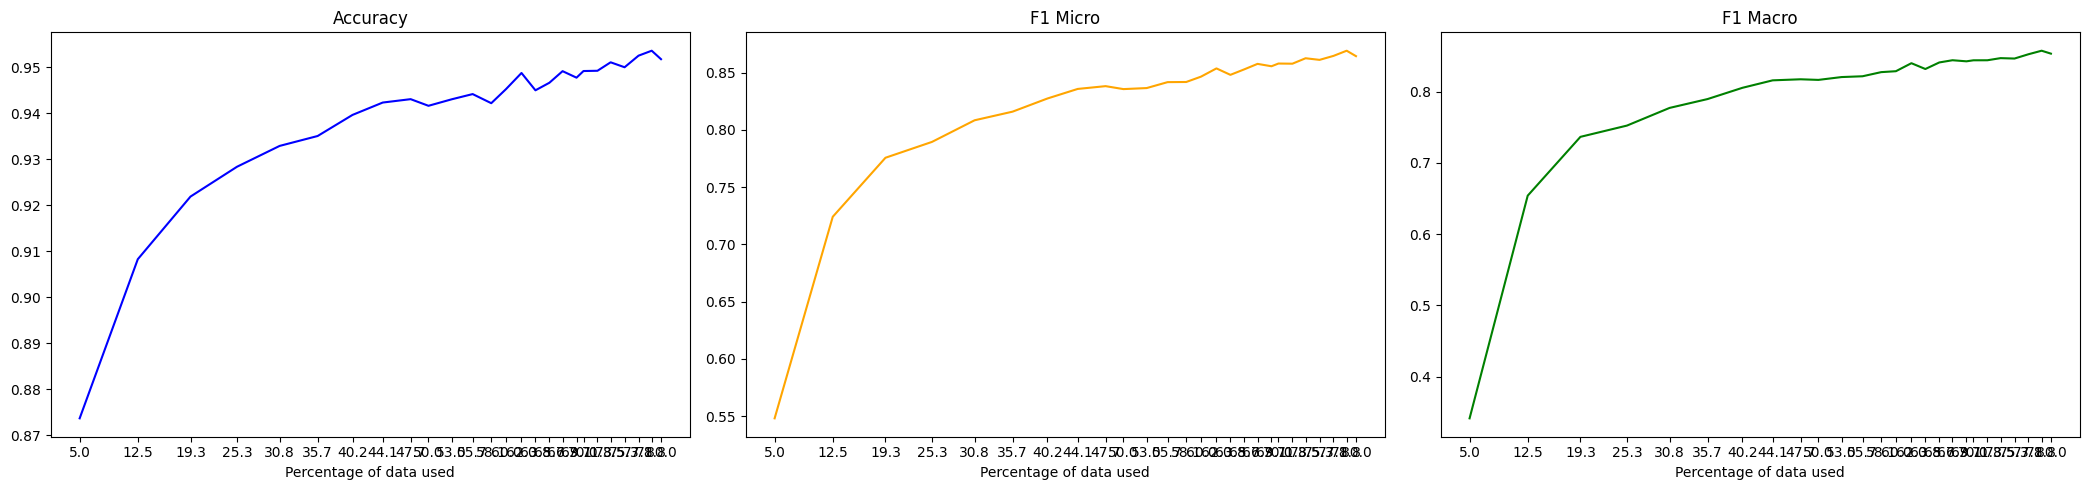

Result saved to results/hsd-random-1-results.csv


In [ ]:
active_learning(42, 0, 'random')